# fazekas distribution per dataset visualization
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
%load_ext autoreload

In [2]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets_v2.mri_dataset_inram import MRISegmentation3DDataset
from twaidata.torchdatasets_v2.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [3]:
import seaborn as sns
import scipy

In [4]:
import proplot as pplt

In [5]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Loading the Fazekas Categories

In [6]:
class_labels = ['C0', 'C1', 'C2', 'C3']
n_classes = 4

In [7]:
%autoreload

In [8]:
from trustworthai.journal_run.new_MIA_fazekas_and_QC.dataset_setup import *

In [9]:
cvd_data, adni_data, challenge_data, mss3_data = load_spreadsheets(include_MSS3=True)

challenge shapes before and after cleanup
(175, 1532)
(175, 1465)
cvd shapes before and after cleanup
(250, 1552)
(250, 1402)
adni shapes before and after cleanup
(299, 1544)
(299, 1374)
mss3 shapes before and after cleanup
(68, 46)
(68, 44)


In [10]:
mss3_data['ssn_ens'][['ID', 'WMH_PV', 'WMH_Deep']][0:10]

,ID,WMH_PV,WMH_Deep
0,MSS3_ED_001_V1,2.0,1.0
1,MSS3_ED_002_V1,3.0,3.0
2,MSS3_ED_003_V1,2.0,2.0
3,MSS3_ED_004_V1,3.0,2.0
4,MSS3_ED_005_V1,1.0,1.0
5,MSS3_ED_006_V1,3.0,2.0
6,MSS3_ED_007_V1,1.0,1.0
7,MSS3_ED_008_V1,3.0,3.0
8,MSS3_ED_009_V1,1.0,1.0
9,MSS3_ED_010_V1,3.0,2.0


### Load and preprocess the per-sample features

In [11]:
adni_spreadsheet_folder = "/home/s2208943/preprocessed_data/ADNI300/ADNI_300_feature_spreadsheets"
cvd_spreadsheet_folder = "/home/s2208943/preprocessed_data/Ed_CVD/EdData_feature_spreadsheets"
challenge_spreadsheet_folder = "/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/feature_spreadsheets"
mss3_spreadsheet_folder = "/home/s2208943/preprocessed_data/MSS3_InterRaterData/feature_spreadsheets"

In [12]:
cvd_sdata = {}
cvd_sdata['ssn_ens'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "ssn_ens_per_sample_new_features_v2.csv"))
cvd_sdata['ssn_ens']['ID'] = cvd_sdata['ssn_ens']['pID']
cvd_sdata['punet'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "punet_per_sample_new_features_v2.csv"))
cvd_sdata['punet']['ID'] = cvd_sdata['punet']['pID']
cvd_sdata['deterministic'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "deterministic_per_sample_new_features_v2.csv"))
cvd_sdata['deterministic']['ID'] = cvd_sdata['deterministic']['pID']

adni_sdata = {}
adni_sdata['ssn_ens'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "ssn_ens_per_sample_new_features_v2.csv"))
adni_sdata['punet'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "punet_per_sample_new_features_v2.csv"))
adni_sdata['deterministic'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "deterministic_per_sample_new_features_v2.csv"))

challenge_sdata = {}
challenge_sdata['ssn_ens'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "ssn_ens_per_sample_new_features_v2.csv"))
challenge_sdata['punet'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "punet_per_sample_new_features_v2.csv"))
challenge_sdata['deterministic'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "deterministic_per_sample_new_features_v2.csv"))

mss3_sdata = {}
mss3_sdata['ssn_ens'] = pd.read_csv(os.path.join(mss3_spreadsheet_folder, "ssn_ens_per_sample_new_features_v2.csv"))
mss3_sdata['ssn_ens']['ID'] = mss3_sdata['ssn_ens']['pID']
mss3_sdata['punet'] = pd.read_csv(os.path.join(mss3_spreadsheet_folder, "punet_per_sample_new_features_v2.csv"))
mss3_sdata['punet']['ID'] = mss3_sdata['punet']['pID']
mss3_sdata['deterministic'] = pd.read_csv(os.path.join(mss3_spreadsheet_folder, "deterministic_per_sample_new_features_v2.csv"))
mss3_sdata['deterministic']['ID'] = mss3_sdata['deterministic']['pID']


In [13]:
def combine_dss(features_df, clin_df):
    features_df = features_df.fillna(0)
    faz_df = clin_df[['ID', 'WMH_PV', 'WMH_Deep']]
    df = pd.merge(features_df, faz_df, on='ID', how='inner')
    df = df.dropna(subset=['WMH_PV', 'WMH_Deep'])
    return df

In [14]:
cvd_sdata['ssn_ens'] = combine_dss(cvd_sdata['ssn_ens'], cvd_data['ssn_ens'])
cvd_sdata['punet'] = combine_dss(cvd_sdata['punet'], cvd_data['punet'])
cvd_sdata['deterministic'] = combine_dss(cvd_sdata['deterministic'], cvd_data['deterministic'])

adni_sdata['ssn_ens'] = combine_dss(adni_sdata['ssn_ens'], adni_data['ssn_ens'])
adni_sdata['punet'] = combine_dss(adni_sdata['punet'], adni_data['punet'])
adni_sdata['deterministic'] = combine_dss(adni_sdata['deterministic'], adni_data['deterministic'])

challenge_sdata['ssn_ens'] = combine_dss(challenge_sdata['ssn_ens'], challenge_data['ssn_ens'])
challenge_sdata['punet'] = combine_dss(challenge_sdata['punet'], challenge_data['punet'])
challenge_sdata['deterministic'] = combine_dss(challenge_sdata['deterministic'], challenge_data['deterministic'])

mss3_sdata['ssn_ens'] = combine_dss(mss3_sdata['ssn_ens'], mss3_data['ssn_ens'])
mss3_sdata['punet'] = combine_dss(mss3_sdata['punet'], mss3_data['punet'])
mss3_sdata['deterministic'] = combine_dss(mss3_sdata['deterministic'], mss3_data['deterministic'])

In [15]:
import scipy.stats

In [16]:
def get_sample_keys(df):
    sample_keys = []
    for key in df.columns:
        if key.startswith("sample_"):
            key_type = "_".join(key.split("_")[2:])
            if key_type not in sample_keys:
                sample_keys.append(key_type)
                
    return sample_keys

In [17]:
def extract_sample_values(df, key):
    key_per_sample = df[[f'sample_{s}_{key}' for s in range(10)]]
    return key_per_sample

In [18]:
def uncertainty_dfs(df, sample_keys):
    df_new = df.copy()
    new_cols = {'ID':df['ID'].values}

    for key in sample_keys:
        key_samples = extract_sample_values(df, key).values.astype(np.float32)
        key_mean = df[f'mean_{key}'].values.reshape(-1, 1).astype(np.float32)
        vd_key_samples = 100 * (key_samples - key_mean) / (key_mean + 1e-5)
        
        new_cols[f'p75_{key}'] = np.percentile(key_samples, 0.75, axis=1)
        new_cols[f'p25_{key}'] = np.percentile(key_samples, 0.25, axis=1)
        new_cols[f'std_{key}'] = np.std(key_samples, axis=1)
        new_cols[f'iqr_{key}'] = scipy.stats.iqr(key_samples, axis=1)
        
        new_cols[f'vd_p75_{key}'] = np.percentile(vd_key_samples, 0.75, axis=1)
        new_cols[f'vd_p25_{key}'] = np.percentile(vd_key_samples, 0.25, axis=1)
        new_cols[f'vd_std_{key}'] = np.std(vd_key_samples, axis=1)
        new_cols[f'vd_iqr_{key}'] = scipy.stats.iqr(vd_key_samples, axis=1)
        # break/
    
    return pd.merge(df, pd.DataFrame(new_cols), on='ID', how='inner')

In [19]:
cvd_sdata['ssn_ens'] = uncertainty_dfs(cvd_sdata['ssn_ens'], get_sample_keys(cvd_sdata['ssn_ens']))
cvd_sdata['punet'] = uncertainty_dfs(cvd_sdata['punet'], get_sample_keys(cvd_sdata['punet']))

adni_sdata['ssn_ens'] = uncertainty_dfs(adni_sdata['ssn_ens'], get_sample_keys(adni_sdata['ssn_ens']))
adni_sdata['punet'] = uncertainty_dfs(adni_sdata['punet'], get_sample_keys(adni_sdata['punet']))

challenge_sdata['ssn_ens'] = uncertainty_dfs(challenge_sdata['ssn_ens'], get_sample_keys(challenge_sdata['ssn_ens']))
challenge_sdata['punet'] = uncertainty_dfs(challenge_sdata['punet'], get_sample_keys(challenge_sdata['punet']))

mss3_sdata['ssn_ens'] = uncertainty_dfs(mss3_sdata['ssn_ens'], get_sample_keys(mss3_sdata['ssn_ens']))
mss3_sdata['punet'] = uncertainty_dfs(mss3_sdata['punet'], get_sample_keys(mss3_sdata['punet']))

### visualize the fazekas categories

In [20]:
np.sort((cvd_sdata['ssn_ens']['WMH_Deep'].value_counts().index))

array([0.00, 1.00, 2.00, 3.00])

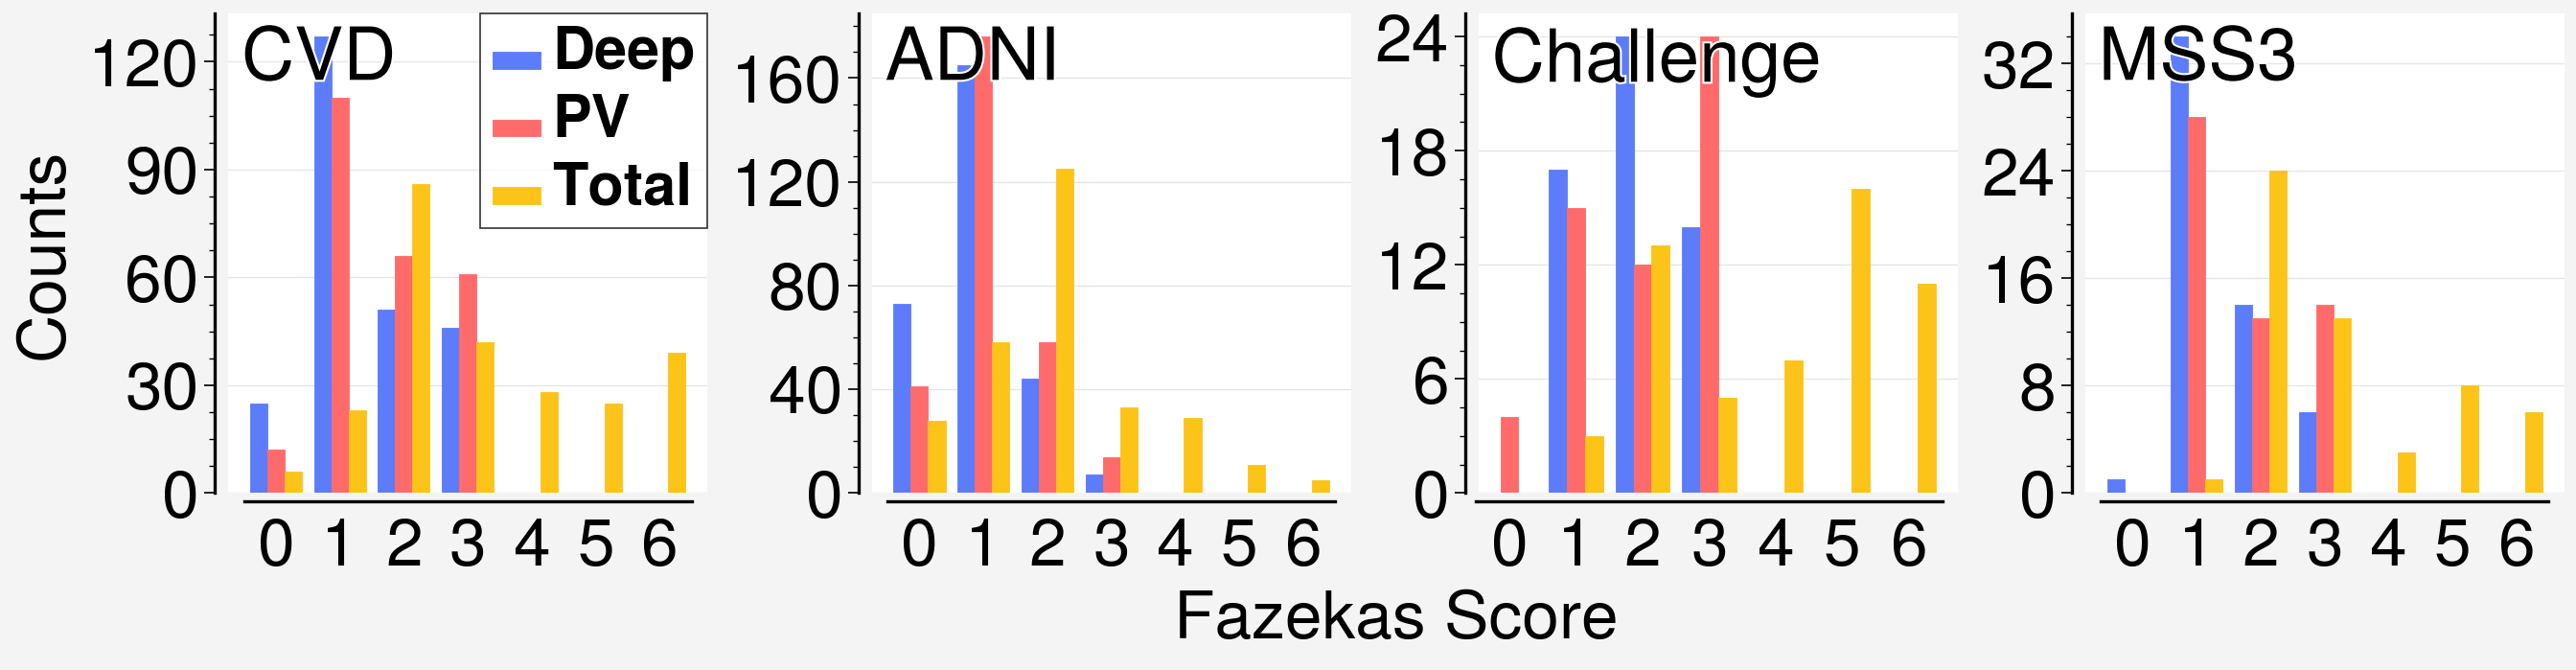

In [46]:
fig, axs = pplt.subplots(nrows=1, ncols=4, spanx=True, spany=False, sharex=True, sharey=False)

for idx, (ax, sdata, name) in enumerate(zip(axs, [cvd_sdata, adni_sdata, challenge_sdata, mss3_sdata], ['CVD', 'ADNI', 'Challenge', 'MSS3'])):
    dwmh = sdata['ssn_ens']['WMH_Deep'].value_counts()
    dwmh_index = np.sort(dwmh.index)
    
    pvwmh = sdata['ssn_ens']['WMH_PV'].value_counts()
    pvwmh_index = np.sort(pvwmh.index)
    
    total = (sdata['ssn_ens']['WMH_Deep'] + sdata['ssn_ens']['WMH_PV']).value_counts()
    total_index = np.sort(total.index)
    
    # Defining the width of the bars and the positions
    width = 0.27
    
    # Plotting the bars
    ax.bar(dwmh_index - width, [dwmh.get(c, 0) for c in dwmh_index], width, label='Deep', c='indigo5', zorder=2)
    ax.bar(pvwmh_index, [pvwmh.get(c, 0) for c in pvwmh_index], width, label='PV', c='red5', zorder=2)
    ax.bar(total_index + width, [total.get(c, 0) for c in total_index], width, label='Total', c='yellow5', zorder=2)
    
    # Adding labels and title
    ax.set_xlabel('Fazekas Score')
    if idx == 0:
        ax.set_ylabel('Counts')
    ax.set_title(name)  # Assuming there is a 'dataset_name' key in sdata
    ax.set_xticks(range(7))
    ax.set_xticklabels(range(7))
    
for idx, ax in enumerate(axs):
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_linewidth(1.2)  # Thicker bottom spine
    ax.spines['left'].set_linewidth(1.2)  # Thicker left spine

    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels 

    ax.spines['bottom'].set_bounds((-0.5, 6.5))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 3))
    
    # horizontal lines only
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)
    ax.grid(False, which='both', axis='x')
    
    if idx == 0:
        legend = ax.legend(ncols=1, fontweight='bold')
        plt.setp(legend.get_texts(), fontsize='22')
        
    # control number of y tick locators
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    
    
axs.format(titleloc='ul', fontsize=25)


fig.save("Fazekas Distributions.pdf")

In [38]:
for ax, sdata, name in zip(axs, [cvd_sdata, adni_sdata, challenge_sdata, mss3_sdata], ['CVD', 'ADNI', 'Challenge', 'MSS3']):
    dwmh = sdata['ssn_ens']['WMH_Deep'].values
    
    pvwmh = sdata['ssn_ens']['WMH_PV'].values
    
    print(name, "deep", f"{np.median(dwmh)}[{np.percentile(dwmh, 25)}, {np.percentile(dwmh, 75)}]")
    print(name, "pv  ", f"{np.median(pvwmh)}[{np.percentile(pvwmh, 25)}, {np.percentile(pvwmh, 75)}]")
    print("---\n")

CVD deep 1.0[1.0, 2.0]
CVD pv   2.0[1.0, 2.0]
---

ADNI deep 1.0[0.0, 1.0]
ADNI pv   1.0[1.0, 1.0]
---

Challenge deep 2.0[1.0, 2.5]
Challenge pv   2.0[1.0, 3.0]
---

MSS3 deep 1.0[1.0, 2.0]
MSS3 pv   1.0[1.0, 2.5]
---

